In [ ]:
!kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset

Dataset URL: https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset
License(s): other
 97%|████████████████████████████████████▊ | 37.0M/38.2M [00:03<00:00, 12.7MB/s]
100%|██████████████████████████████████████| 38.2M/38.2M [00:03<00:00, 12.2MB/s]


### Dataset Explanation

***USA Real Estate Dataset Updated v3 (300k+ entries) & 174 MB of data***

This dataset contains Real Estate listings in the US broken by State and zip code. (simple dataset for regression/clustering problem). Data was collected via web scraping using python libraries.

List of Attributes:

1. status: The current condition or availability of the property, such as "for sale," "sold," "pending," or "under contract"
2. price: The listed or selling price of the property (in USD)
3. bed: The number of bedrooms 
4. bath: The number of bathrooms 
5. acre_lot: The size of the lot. One acre equals 43,560 square feet.
6. full_address: The complete address of the property
7. street: The street name or number where the property is located ("Ave", "Rd", "St" ...)
8. city: The city 
9. state: The state or province 
10. zip_code: The postal code 
11. house_size: The total living area in square foot (1000 foot squared) is 93 meters squared
12. sold_date: The date when the property was sold or when the transaction was completed, indicating when the ownership officially transferred from the seller to the buyer.


Data Cleaning:

1. Extracted from the dataset only relevant columns (attributes: bed, bath, acre_lot, house_size, city, state, zip code, price)
2. Removed rows with unwanted states
3. Filtered to keep only the top 10 most frequent states
4. Removed rows with null values
5. Convert objects (non integers) to numerical format for machine to understand
6. Drop rows with missing `price` since it's the label
7. Remove rows with houses that have more than 10 beds or 10 baths, usually those arent houses but appartment complexes and skews our data

Memory Optimization:

- Convert column to more specific data type to reduce memory usage (float 64 to float 32)


Notes:

Some "houses" represent entire unit complexes (e.g., apartment buildings) one approach is to adjust the price per unit by dividing the price by the house size (square footage). This could provide a more meaningful "price per square foot" and might make more sense for comparison. Remove Rows with More Than 10 Bathrooms or 10 beds. 


In [53]:
import zipfile

with zipfile.ZipFile("usa-real-estate-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("usa_real_estate")

In [76]:
import pandas as pd

# Load dataset
data = pd.read_csv('./usa_real_estate/realtor-data.zip.csv', usecols=['bed', 'bath', 'acre_lot', 'house_size', 'city', 'state', 'zip_code', 'price'])

# Display the first five rows
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   price       float64
 1   bed         float64
 2   bath        float64
 3   acre_lot    float64
 4   city        object 
 5   state       object 
 6   zip_code    float64
 7   house_size  float64
dtypes: float64(6), object(2)
memory usage: 135.9+ MB


In [77]:
# Data Overview:
print("\nDataset Info:\n")
data.info()

# Data Cleaning:
data = data.dropna()                                            # drop all rows with any missing values
unique_states = data['state'].unique()                          # all states available in dataset
states_to_remove = {'Puerto Rico', 'Virgin Islands', 'New Jersey', 'Tennessee', 
                    'Rhode Island',  'Wyoming',  'West Virginia', 'Delaware', 'Louisiana', 'Ohio', 
                    'Wisconsin', 'Kentucky', 'Mississippi', 'Alabama','New Brunswick', 'Texas', 
                    'Arkansas', 'Idaho', 'Indiana', 'New Mexico', 'Iowa', 'Minnesota', 'South Dakota', 
                    'Nebraska', 'North Dakota', 'Montana', 'Oklahoma', 'Oregon', 'Utah', 'Nevada',
                    'Arizona', 'Guam', 'Alaska'}                # set of states to remove, faster look up time compared to list

data = data[~data['state'].isin(states_to_remove)]              # removing all rows with states we dont wnat

top_states = data['state'].value_counts().nlargest(10).index        # count the frequency of each state and keep the 10 most frequent ones
data = data[data['state'].isin(top_states)]                         # filter data to keep only the top 10 most frequent states


print("\nMissing Values per Column:\n")
print(data.isnull().sum())                                                              # print missing values 
data = pd.get_dummies(data, columns=['city', 'state'], drop_first=True, sparse=True)    # objects need to be converted to numerical format for machine to understand
data = data.dropna(subset=['price'])                                                    # drop rows with missing `price` since it's the label

data = data.query('bed <= 20 and bath <= 10') # remove rows with more than 20 beds or with more than 10 baths

data.info()


Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2226382 entries, 0 to 2226381
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   price       float64
 1   bed         float64
 2   bath        float64
 3   acre_lot    float64
 4   city        object 
 5   state       object 
 6   zip_code    float64
 7   house_size  float64
dtypes: float64(6), object(2)
memory usage: 135.9+ MB

Missing Values per Column:

price         0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 657491 entries, 5217 to 2226381
Columns: 7762 entries, price to state_Washington
dtypes: Sparse[bool, False](7756), float64(6)
memory usage: 40.6 MB


In [78]:
# Useful features for prediction
features = ['bed', 'bath', 'acre_lot', 'house_size', 'city', 'state', 'zip_code']
label = 'price'  # we choose to forecast house prices in area

# Memory optimization
data['price'] = data['price'].astype('float32')
data['bed'] = data['bed'].astype('float32')
data['bath'] = data['bath'].astype('float32')
data['acre_lot'] = data['acre_lot'].astype('float32')
data['zip_code'] = data['zip_code'].astype('category').cat.codes
data['house_size'] = data['house_size'].astype('float32')

data.info()  # Summary of the dataset
data.describe()  # Basic statistics for numerical features

<class 'pandas.core.frame.DataFrame'>
Index: 657491 entries, 5217 to 2226381
Columns: 7762 entries, price to state_Washington
dtypes: Sparse[bool, False](7756), float32(5), int16(1)
memory usage: 24.3 MB


,price,bed,bath,acre_lot,zip_code,house_size
count,6.574910e+05,657491.000000,657491.000000,657491.000000,657491.000000,6.574910e+05
mean,6.675592e+05,3.369483,2.564391,19.405258,5980.524702,2.047545e+03
std,1.331607e+06,1.104819,1.146739,1062.768066,2594.040834,2.344446e+03
min,1.000000e+00,1.000000,1.000000,0.000000,0.000000,1.000000e+02
25%,2.750000e+05,3.000000,2.000000,0.130000,3908.000000,1.333000e+03
50%,4.350000e+05,3.000000,2.000000,0.210000,6292.000000,1.772000e+03
75%,7.100000e+05,4.000000,3.000000,0.440000,8268.000000,2.412000e+03
max,5.150000e+08,20.000000,10.000000,100000.000000,10080.000000,1.560780e+06


## Data Visualization

['state_Florida', 'state_Georgia', 'state_Illinois', 'state_Maryland', 'state_New York', 'state_North Carolina', 'state_Pennsylvania', 'state_Virginia', 'state_Washington']


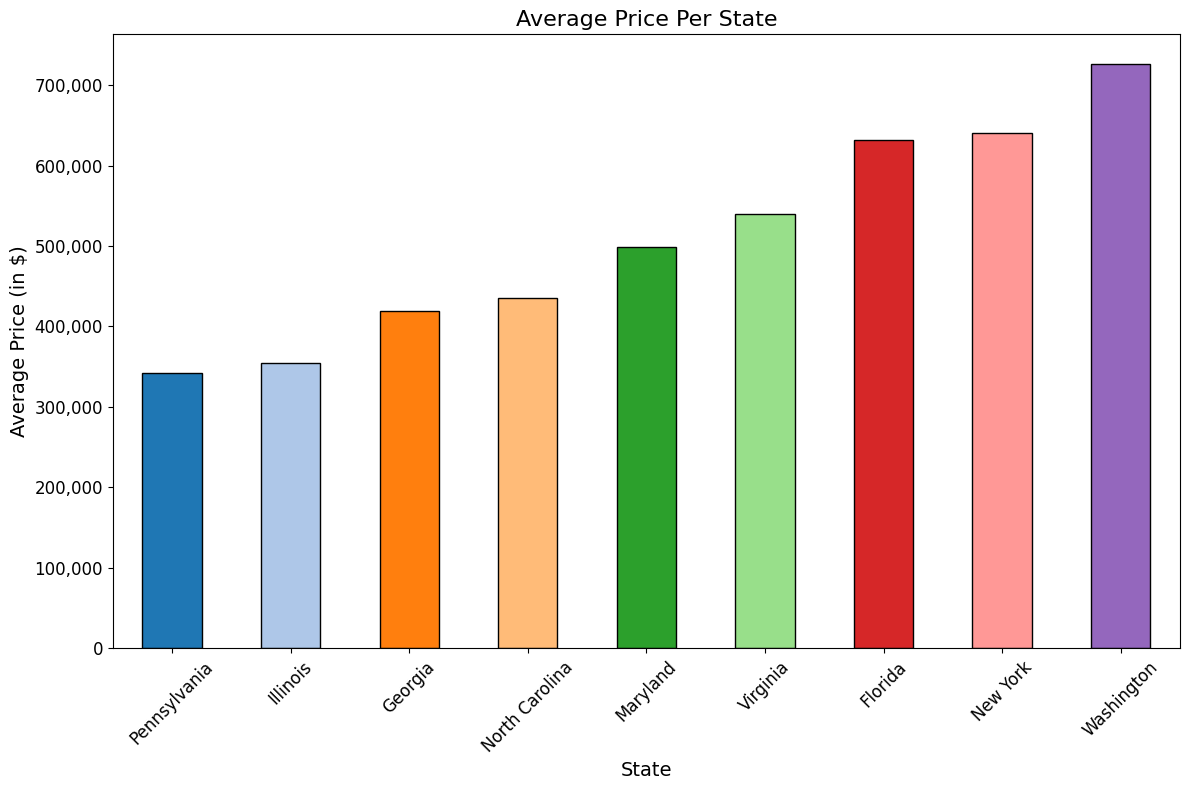

In [79]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd

# calculate average price using one-hot encoded state columns
state_cols = [col for col in data.columns if col.startswith('state_')]
print(state_cols)

state_prices = {}
for col in state_cols:
    state_name = col.replace('state_', '')
    avg_price = data.loc[data[col] == 1, 'price'].mean()
    state_prices[state_name] = avg_price

# Convert to Pandas Series for plotting
state_avg_price = pd.Series(state_prices).sort_values()

# Plotting
plt.figure(figsize=(12, 8))

# Generate a color palette with a different color for each state
colors = plt.cm.tab20(range(len(state_avg_price)))

# Plot the bar chart
state_avg_price.plot(
    kind='bar',
    color=colors,
    edgecolor='black'
)

# Update title, labels, and ticks
plt.title('Average Price Per State', fontsize=16)
plt.ylabel('Average Price (in $)', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Format y-axis to display values in the appropriate scale (in millions)
formatter = mticker.FuncFormatter(lambda x, _: f'{x:,.0f}')
plt.gca().yaxis.set_major_formatter(formatter)

# Tidy up layout
plt.tight_layout()
plt.show()


In [80]:
# Print all attributes (Dummy values)
print("Dataset Columns:\n")
print(data.columns.tolist())

Dataset Columns:

['price', 'bed', 'bath', 'acre_lot', 'zip_code', 'house_size', 'city_Abbeville', 'city_Abbottstown', 'city_Abell', 'city_Aberdeen', 'city_Abingdon', 'city_Abington', 'city_Acampo', 'city_Accident', 'city_Accokeek', 'city_Accomac', 'city_Accord', 'city_Acme', 'city_Acra', 'city_Acton', 'city_Acworth', 'city_Adah', 'city_Adair', 'city_Adairsville', 'city_Adams', 'city_Adams Center', 'city_Adamstown', 'city_Adamsville', 'city_Addieville', 'city_Addisleigh Park', 'city_Addison', 'city_Addy', 'city_Adel', 'city_Adelanto', 'city_Adelphi', 'city_Adin', 'city_Adirondack', 'city_Adna', 'city_Adrian', 'city_Advance', 'city_Afton', 'city_Agoura', 'city_Agoura Hills', 'city_Agua Dulce', 'city_Agua Fria', 'city_Aguanga', 'city_Ahoskie', 'city_Ahwahnee', 'city_Aiken', 'city_Ailey', 'city_Airmont', 'city_Airville', 'city_Airway Heights', 'city_Akron', 'city_Alabama', 'city_Alachua', 'city_Alameda', 'city_Alamo', 'city_Alapaha', 'city_Albany', 'city_Albemarle', 'city_Alberta', 'city_

In [ ]:
# Filter for New York state
ny_data = data[data['state_New York'] == 1]

# Check how many rows are from New York
print(f"Total rows in New York state: {len(ny_data)}")

# List top cities in New York by frequency
ny_city_cols = [col for col in ny_data.columns if col.startswith('city_')]
city_counts = {col: ny_data[col].sum() for col in ny_city_cols}
sorted_cities = sorted(city_counts.items(), key=lambda x: x[1], reverse=True)

# display top 10 cities in New York
print("\nTop 10 Cities in New York by Frequency:")
for city, count in sorted_cities[:10]:
    print(f"{city}: {count} properties")


Total rows in New York state: 86352

Top 10 Cities in New York by Frequency:
city_New York City: 11236 properties
city_Brooklyn: 4928 properties
city_New York: 4648 properties
city_Staten Island: 2403 properties
city_Rochester: 2225 properties
city_Bronx: 1543 properties
city_Buffalo: 1502 properties
city_Syracuse: 965 properties
city_Albany: 866 properties
city_Flushing: 823 properties


In [81]:
# Filter for NYC within New York State
nyc_data = ny_data[ny_data['city_New York'] == 1]

# Check how many rows are in NYC
print(f"Total rows in NYC: {len(nyc_data)}")

# Preview NYC-specific data
print("\nSample NYC Data:")
print(nyc_data.head())

Total rows in NYC: 4648

Sample NYC Data:
           price  bed  bath  acre_lot  zip_code  house_size  \
45730  1185000.0  2.0   2.0       NaN   10021.0         NaN   
46124   895000.0  2.0   2.0       NaN   10022.0      1425.0   
46126   985000.0  1.0   2.0       NaN   10005.0      1166.0   
46127   810000.0  1.0   1.0       NaN   10065.0       761.0   
46133   740000.0  2.0   2.0       NaN   10031.0         NaN   

       city_15th Ave Milton  city_21 27 Tommie Lane  city_Aaronsburg  \
45730                 False                   False            False   
46124                 False                   False            False   
46126                 False                   False            False   
46127                 False                   False            False   
46133                 False                   False            False   

       city_Abbeville  ...  city_Zuni  state_Florida  state_Georgia  \
45730           False  ...      False          False          False   
4612

In [83]:
# Normalize numerical features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

nyc_data[['bed', 'bath', 'acre_lot', 'house_size']] = scaler.fit_transform(
    nyc_data[['bed', 'bath', 'acre_lot', 'house_size']]
)

print("\nProcessed NYC Data:")
print(nyc_data.head())



Processed NYC Data:
            price       bed      bath  acre_lot  zip_code  house_size
47111    389000.0 -1.339078 -1.079763  2.509545   10032.0    5.389098
47588   4200000.0  0.983812  1.708486 -0.710248   10022.0   -0.021970
48932  32500000.0  1.912968  2.173194 -0.441932   10021.0    1.060686
49707    625000.0 -0.409922 -1.079763 -0.307774   10458.0   -0.333155
49912    899000.0 -1.339078 -1.079763  1.838754   10025.0   -0.499808


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Define features (X) and target (y)
X = nyc_data.drop('price', axis=1)
y = nyc_data['price']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error on NYC Data: ${mae:,.2f}")


Mean Absolute Error on NYC Data: $3,804,701.43


In [94]:
from sklearn.metrics import mean_squared_error
import numpy as np

mse = mean_squared_error(y_test, y_pred)

rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: ${rmse:,.2f}")
print(f"Mean Price: ${y.mean():,.2f}")
print(f"Min Price: ${y.min():,.2f}")
print(f"Max Price: ${y.max():,.2f}")
print(f"25th Percentile: ${y.quantile(0.25):,.2f}")
print(f"50th Percentile (Median): ${y.quantile(0.50):,.2f}")
print(f"75th Percentile: ${y.quantile(0.75):,.2f}")

Root Mean Squared Error: $6,171,318.10
Mean Price: $3,332,470.50
Min Price: $119,000.00
Max Price: $32,500,000.00
25th Percentile: $701,749.75
50th Percentile (Median): $1,697,500.00
75th Percentile: $3,073,750.00


In [96]:
print(max(y))

32500000.0


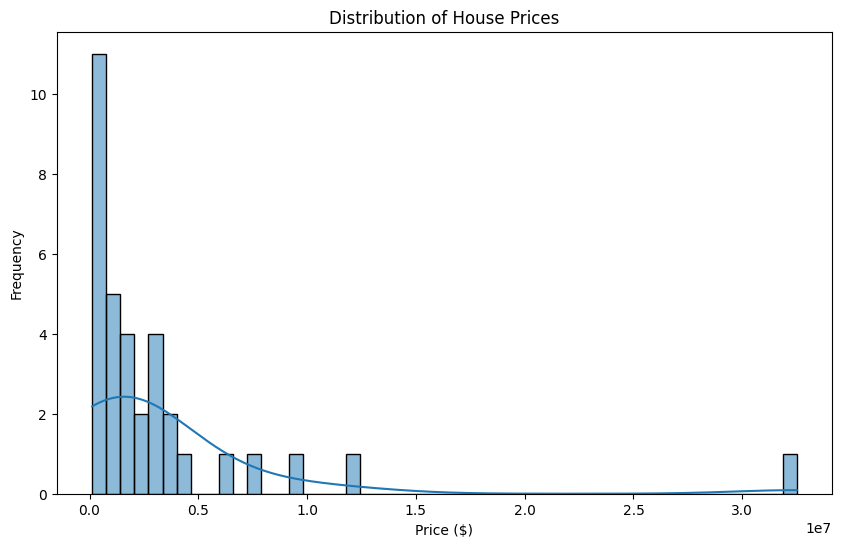

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.show()
